## <b>Import libraries<b>

In [51]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score
from sklearn import model_selection
%matplotlib inline

In [2]:
#drew inspiration from
#https://github.com/dmesquita/understanding_pytorch_nn and
#https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb
#https://github.com/nyu-mll/DS-GA-1011-Fall2017/blob/master/week%20eight/Week%20Eight%20Solutions.ipynb
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#https://github.com/claravania/lstm-pytorch/blob/master/model.py
#https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130
#https://github.com/hpanwar08/sentence-classification-pytorch/blob/master/Sentiment%20analysis%20pytorch.ipynb

In [ ]:
#https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
#https://github.com/Blosc/bcolz

#used pip install -U blosc

In [ ]:
#https://modelzoo.co/model/pytorch-nlp
#http://anie.me/On-Torchtext/
#https://readthedocs.org/projects/pytorchnlp/downloads/pdf/latest/

#https://github.com/A-Jacobson/CNN_Sentence_Classification/blob/master/WordVectors.ipynb
#https://pytorch.org/docs/master/nn.html#torch.nn.Embedding.from_pretrained

In [12]:
from torchnlp.word_to_vector import GloVe #glove is much smaller than fastext, so downloads faster

In [15]:
vectors['hello'] #it works! embedding length is 300


 0.2523
 0.1018
-0.6748
 0.2112
 0.4349
 0.1654
 0.4826
-0.8122
 0.0413
 0.7850
-0.0779
-0.6632
 0.1464
-0.2929
-0.2549
 0.0193
-0.2026
 0.9823
 0.0283
-0.0813
-0.1214
 0.1313
-0.1765
 0.1356
-0.1636
-0.2257
 0.0550
-0.2031
 0.2072
 0.0958
 0.2248
 0.2154
-0.3298
-0.1224
-0.4003
-0.0794
-0.1996
-0.0151
-0.0791
-0.1813
 0.2068
-0.3620
-0.3074
-0.2442
-0.2311
 0.0980
 0.1463
-0.0627
 0.4293
-0.0780
-0.1963
 0.6509
-0.2281
-0.3031
-0.1248
-0.1757
-0.1465
 0.1536
-0.2952
 0.1510
-0.5173
-0.0336
-0.2311
-0.7833
 0.0180
-0.1572
 0.0229
 0.4964
 0.0292
 0.0567
 0.1462
-0.1919
 0.1624
 0.2390
 0.3643
 0.4526
 0.2456
 0.2380
 0.3140
 0.3487
-0.0358
 0.5611
-0.2535
 0.0520
-0.1062
-0.3096
 1.0585
-0.4202
 0.1822
-0.1126
 0.4058
 0.1178
-0.1971
-0.0753
 0.0807
-0.0278
-0.1562
-0.4468
-0.1516
 0.1692
 0.0983
-0.0319
 0.0871
 0.2608
 0.0027
 0.1319
 0.3444
-0.3789
-0.4114
 0.0816
-0.1167
-0.4371
 0.0111
 0.0994
 0.2661
 0.4002
 0.1890
-0.1844
-0.3036
-0.2725
 0.2247
-0.4061
 0.1562
-0.1604
 0.4715

## <b> Data Processing<b>

In [52]:
train = pd.read_csv("../train_nn.csv")

In [4]:
#create labels

In [53]:
labels = ['CAPS', 'Obscenity', 'Threat', 'hatespeech', 'namecalling', 'negprejudice', 'noneng', 'porn', 'stereotypes']

for label in labels:
    cols = [label + str(x) for x in range(1,8)]
    train[label + '_num_yes'] = train[cols].sum(axis = 1)
    train[label] = pd.Series(train[label + '_num_yes'] >= 2).astype(int)

In [54]:
train = train.loc[train['clean_tweet'].isnull() == False,]

In [55]:
train.reset_index(inplace = True, drop = True)

In [58]:
vocab = Counter()

for text in train.clean_tweet:
    for word in text.split(' '):
        vocab[word.lower()]+=1

total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    index2word = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i+1
        index2word[i+1] = word.lower()

    return word2index, index2word

word2index, index2word = get_word_2_index(vocab)

In [61]:
#should add 'UNK' here

word2index['PAD'] = 0
index2word[0] = 'PAD'

total_words = total_words + 1

In [60]:
def load_glove_embeddings(path, word2idx):
    with open(path) as f:
        embeddings = np.zeros((len(word2idx), embedding_dim))
        for line in f.readlines():
            values = line.split()
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

In [166]:
word2index['hello']

2433

In [178]:
vectors['dskjds'] == vectors['adsdlkdsakld']


 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.ByteTensor of size 300]

In [145]:
matrix_len = len(vocab) + 1
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in index2word.items():
    try: 
        weights_matrix[i] = vectors[index2word[i]].numpy()
        words_found += 1
    except KeyError:
        key_errors +=1
        weights_matrix[i] = np.zeroes( size=(300, ))

In [170]:
weights_matrix[2433, ] #confirmed that at index "hello" we're seeing the glove vector for "hello"

array([ 0.25233001,  0.10176   , -0.67484999,  0.21117   ,  0.43492001,
        0.16542   ,  0.48260999, -0.81221998,  0.041321  ,  0.78501999,
       -0.077857  , -0.66324002,  0.1464    , -0.29289001, -0.25488001,
        0.019293  , -0.20265   ,  0.98232001,  0.028312  , -0.081276  ,
       -0.1214    ,  0.13125999, -0.17648   ,  0.13556001, -0.16361   ,
       -0.22574   ,  0.055006  , -0.20308   ,  0.20717999,  0.095785  ,
        0.22481   ,  0.21537   , -0.32982001, -0.12241   , -0.40031001,
       -0.079381  , -0.19958   , -0.015083  , -0.079139  , -0.18132   ,
        0.20681   , -0.36195999, -0.30744001, -0.24422   , -0.23113   ,
        0.09798   ,  0.1463    , -0.062738  ,  0.42934   , -0.078038  ,
       -0.19627   ,  0.65092999, -0.22807001, -0.30307999, -0.12483   ,
       -0.17568   , -0.14651   ,  0.15361001, -0.29517999,  0.15098999,
       -0.51726002, -0.033564  , -0.23108999, -0.78329998,  0.018029  ,
       -0.15719   ,  0.02293   ,  0.49639001,  0.029225  ,  0.05

In [147]:
len(vocab.keys())

11320

In [179]:
weights_matrix.shape

(11321, 300)

In [187]:
weights = torch.FloatTensor(weights_matrix)

In [194]:
sum(weights.sum(dim = 1) == 0) #2,529 words initialized to zero vectors

2529

In [151]:
def pad_data(s, length):
    padded = np.zeros((length,), dtype = np.int64)
    if len(s) > length: 
        padded = s[:length]
    else:
        padded[:len(s)] = s
    return np.array(padded)

In [152]:
train['seq_len'] = [len(x.split(' ')) for x in train['clean_tweet']]

train['numeric'] = [[word2index[y] for y in x.split(' ')] for x in train['clean_tweet']]

train['padded_tweet'] = [pad_data(x, 10) for x in train.numeric]

In [12]:
#if we want validation accuracy to better resemble test accuracy, need to create vocab on training only

In [153]:
train_sub, validation = model_selection.train_test_split(train, test_size = 0.2, random_state = 123)

In [154]:
# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df, label, maxlen=20):
        self.df = df
        self.label = label

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.padded_tweet[idx]
        y = self.df[self.label][idx]
        lens = self.df.seq_len[idx]
        return X,y,lens

In [155]:
train_sub.reset_index(inplace = True, drop = True)

In [156]:
validation.reset_index(inplace = True, drop = True)

In [157]:
data = VectorizeData(train_sub, label = 'hatespeech')

dl = DataLoader(data, batch_size = 32, shuffle = True)

In [158]:
class LSTMClassifier(nn.Module):
    def __init__(self, weights, vocab_size, embedding_dim, hidden_dim, output_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        self.dropout_layer = nn.Dropout(p=0.2)
        self.batch_size = batch_size
        #self.hidden = self.init_hidden(batch_size)

    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)), \
               autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch):
        #print (batch.size()) #seq length x batch_size
        #should reinitalize hidden states before each batch?
        self.hidden = self.init_hidden(batch_size)
        embeds = self.embedding(batch)
        embeds.weight = nn.Parameter(self.weights)
        #print (embeds.size()) #10 x 32 x 300 (hidden size)
        #packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(embeds, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)
        return output

In [159]:
hidden_size = 300 
num_classes = 2
learning_rate = 0.01
num_epochs = 10
batch_size = 32

In [160]:
def get_validation_loss(validation_data_loader, model):
    predictions = []
    pred_labels = []
    #get training predictions
    it = iter(validation_data_loader)
    num_batch = len(validation_data_loader) - 1
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        outputs = model(tweets)
        _, pred = torch.max(outputs.data, 1)
        predictions.extend(list(pred.numpy()))
        pred_labels.extend(list(labels.data.numpy()))
    return (f1_score(pred_labels, predictions))

In [161]:
#add 1 because of pad token
net = LSTMClassifier(weights, total_words, hidden_size, hidden_size, num_classes, batch_size)

# Loss and Optimizer
criterion = nn.NLLLoss(weight = torch.Tensor([1/39,1]))  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Validation Data
val = VectorizeData(validation, label = 'hatespeech')
dl2 = DataLoader(val, batch_size = 32, shuffle = False)

losses = []
val_scores = []

num_batch = len(dl) - 1
# Train the Model
for epoch in range(num_epochs):
    it = iter(dl)
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(tweets)
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train.clean_tweet)//batch_size, loss.data[0]))
            val_scores.append(get_validation_loss(dl2, net))

Epoch [1/10], Step [4/124], Loss: 0.6640
Epoch [1/10], Step [8/124], Loss: 0.1648
Epoch [1/10], Step [12/124], Loss: 1.7108
Epoch [1/10], Step [16/124], Loss: 0.8377
Epoch [1/10], Step [20/124], Loss: 1.7438
Epoch [1/10], Step [24/124], Loss: 0.3244
Epoch [1/10], Step [28/124], Loss: 0.3029
Epoch [1/10], Step [32/124], Loss: 0.3122
Epoch [1/10], Step [36/124], Loss: 1.1024
Epoch [1/10], Step [40/124], Loss: 0.5750
Epoch [1/10], Step [44/124], Loss: 0.3674
Epoch [1/10], Step [48/124], Loss: 0.5115
Epoch [1/10], Step [52/124], Loss: 0.2179
Epoch [1/10], Step [56/124], Loss: 0.2722
Epoch [1/10], Step [60/124], Loss: 0.3355
Epoch [1/10], Step [64/124], Loss: 0.1212
Epoch [1/10], Step [68/124], Loss: 3.7834
Epoch [1/10], Step [72/124], Loss: 0.6315
Epoch [1/10], Step [76/124], Loss: 0.6679
Epoch [1/10], Step [80/124], Loss: 1.1812
Epoch [1/10], Step [84/124], Loss: 0.5271
Epoch [1/10], Step [88/124], Loss: 0.2910
Epoch [1/10], Step [92/124], Loss: 0.1906
Epoch [1/10], Step [96/124], Loss: 0

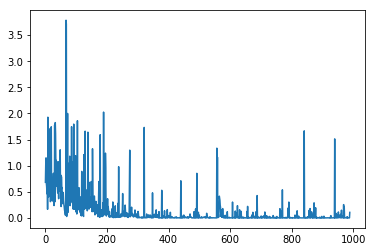

In [172]:
plt.plot(losses)

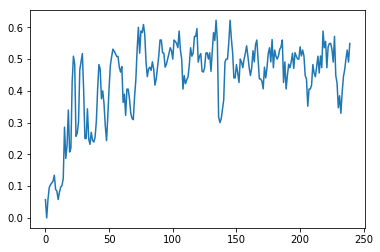

In [171]:
plt.plot(val_scores)